# Zillow Report

### Objectives of this notebook:

1. Provide a model that can predict home value of single unit properties that the tax district assessed during the months of May 2017 - June 2017, using number of bedrooms, number of bathrooms, and square feet of the property as features. 

1. Evaluate and work on different models to see if there are more effective predictor of home value.

1. Find the location of the properties, and display the tax rate for each county that a property is located in

1. Provide insight and further explanation onto some of the decision making that went into creating the outcome of this project.

### Inital Hypothesis

* $H_0$: Using `bedroom cnt`, `bathroom cnt` and `square foot` for modeling is not significantly better than the mean baseline.
* $H_1$: Using `bedroom cnt`, `bathroom cnt` and `square foot` for modeling is significantly better than the mean baseline.

## Imports

In [1]:
import pandas as pd
import wrangle_zillow
import feature_engineering
import split_scale
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from math import sqrt
from scipy import stats
from pydataset import data
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
import env
from sklearn.metrics import explained_variance_score
import explore
import seaborn as sns
import evaluate
import sklearn.metrics

In [2]:
wrangle_zillow.check_for_json_file("zillow_plain_data.csv")

## Wrangle

In [3]:
plain_data = wrangle_zillow.wrangle_plain_data()

For this particular project, the data is pulled from the Sequel Pro database that the Zillow team provided us. The data is brought onto a Pandas Dataframe with some filters already in place. 

The query used is below for reference:

```
SELECT *
FROM properties_2017
JOIN predictions_2017 USING(id)
WHERE (predictions_2017.transactiondate >= '2017-05-01' AND predictions_2017.transactiondate <= '2017-06-30')
	AND propertylandusetypeid = "261"
	AND bathroomcnt > 0
	AND bedroomcnt > 0
	AND calculatedfinishedsquarefeet > 0
	AND taxamount > 0
	AND taxvaluedollarcnt > 0
;
```

Given that ceirtain features, like `bedroomcnt` and `bathroomcnt` have already been highlighted by the Zillow team as important, I made sure the data had no null values for those features. The data also only contains houses that had a transaction date between May 2017, and June 2017, as specified in the brief, and are classified are "single family unit".

In [4]:
plain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15956 entries, 0 to 15955
Data columns (total 64 columns):
Unnamed: 0                      15956 non-null int64
id                              15956 non-null int64
parcelid                        15956 non-null int64
airconditioningtypeid           4002 non-null float64
architecturalstyletypeid        11 non-null float64
basementsqft                    5 non-null float64
bathroomcnt                     15956 non-null float64
bedroomcnt                      15956 non-null float64
buildingclasstypeid             0 non-null float64
buildingqualitytypeid           12357 non-null float64
calculatedbathnbr               15951 non-null float64
decktypeid                      56 non-null float64
finishedfloor1squarefeet        788 non-null float64
calculatedfinishedsquarefeet    15956 non-null float64
finishedsquarefeet12            15921 non-null float64
finishedsquarefeet13            0 non-null float64
finishedsquarefeet15            0 non-

When the data is pulled into Pandas, we have a lot of different categories, as well as a lot of null values. It is at this point that I began wrangling the data so that it was in a more usable format. 

To clean the data, I took the following steps: 

1. In order to deal with the null values, I dropped features that had more than 10,000 null values 
    * The data pulled from SQL comes with 15,956 rows. Some features had as little as 11 values, and as such, I couldn't just drop all null values. After I dropped the categories with low values, then it was more sensible to drop all remaining null values, bringing the total number of values to 11,886, which is still a considerable size, and now we have more continues categories that can potentially be used to improve the model's performance. 
1. As per the brief's specification, we also wanted to include geographical information that wasn't available in the core dataset. 
    * Using the `fibs` value, it was possible to find the county and state that a house was in. Using the table (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697), it was possible to add the geographical information by merging this table into our core database. 
    * The only tweak to the data needed was to convert `fibs` from a `float` to an `int` dtype.
1. To make it easier to read, I also changed the column names for the key values. The changes are outlined in the table below:

Original Name |  New Name 
--------------|------------
`bathroomcnt` | `bathrooms`
`bedroomcnt` |  `bedrooms` 
`calculatedfinishedsquarefeet` | `square_feet` 
`taxvaluedollarcnt` | `house_value` 
`landtaxvaluedollarcnt` | `tax_amount` 

4. These particular values were selected for the following reasons:
    * `bathroomcnt` was selected over `calculatedbathnbr` because it has less null values. After doing some research, it turns out that the `calculatedbathnbr` is the number of bathrooms calculated by Zillow, while `bathroomcnt` is what the tax assessors are reporting. After calculating the percent difference between both categories, there was a 4% difference, I decided was small enough for me to treat both categories as equal. 
    * `calculatedfinishedsquarefeet` was selected over all the other square feet calculations because, based on research, the `calculatedfinishedsquarefeet` is calcualted by Zillow, and it is considered to be a much more accurate indicator. 

5. There was a small number of extreme outliers, particularly in the number of bathrooms and square_feet. To improve the model, these were removed.
    * Houses that had more than 7 bathrooms were removed (45 rows)
    * Houses with more than 5,000 square meters were removed (125 rows)
    * Houses with more than 6 bedrooms were removed (23 rows) 
    * In total, it was a small amount of rows, but because some of the outliers were so extreme, they were affecting the model.

In [5]:
zillow_data = wrangle_zillow.wrangle_zillow()

In [6]:
zillow_data = wrangle_zillow.remove_outliers(zillow_data)

## Split and Scale

We are now ready to split and scale the data. For this model, the `train_size` has been set to .8, and the `random_state` has been set to 123, for reproducibility purposes. 

In [7]:
train, test = split_scale.split_my_df(zillow_data)

In [8]:
print(f"The number of rows for our train dataset is now: {train.shape[0]}, and for our test dataset: {test.shape[0]}")

The number of rows for our train dataset is now: 9380, and for our test dataset: 2345


In [9]:
train_mvp = wrangle_zillow.wrangle_mvp(train)
test_mvp = wrangle_zillow.wrangle_mvp(test)

In [10]:
assert(train_mvp.shape[0]) == train.shape[0]
assert(test_mvp.shape[0]) == test.shape[0]

Now that the data is split, I used a custome function to pull the key categories from the dataframe, allowing for easier modeling and testing before diving into other categories. We use the `assert` function to ensure that the number of rows matches our train and test datasets.

Next we divide our data into our X and y values, to preprare it for modeling

In [11]:
X_train_mvp = train_mvp.drop(columns = "house_value")
y_train_mvp = train_mvp[["house_value"]]
X_test_mvp = test_mvp.drop(columns = "house_value")
y_test_mvp = test_mvp[["house_value"]]

Given that we have multiple features that we will be combining to predict our target variable, and the fact that the individual features consist of differnt kinds of continuos data, it is important to scale them. Below I used a custom function to scale the key features. I used a Min_Max_Scaler because it is a linear scaler.

In [12]:
scaler, trained_scaled, test_scaled = split_scale.min_max_scaler(X_train_mvp, X_test_mvp)

## Explore

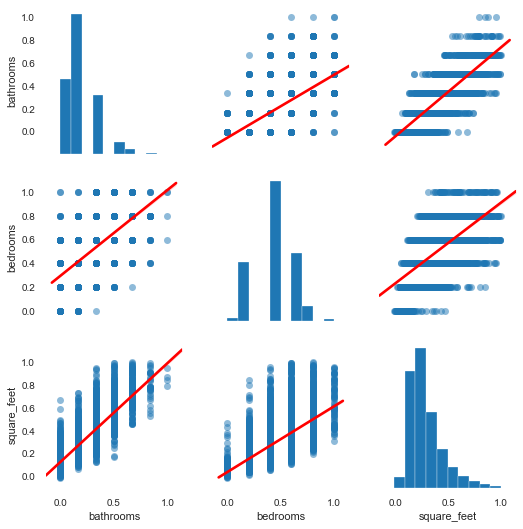

In [13]:
explore.plot_variable_pairs(trained_scaled)

By looking at the pairplot above, we can see that all of the key features are highly correlated to each other. This could be a problem when it comes to modeling, as it could mean that they are highly dependent on each other, and this would affect our linear regression model. To further check this hypothesis, I did a Pearsons-R test on both bedrooms and bathrooms and concluded that, because of the r value being above .5 and our p value being below 0.05, we can be confident that these two variable are highly correlated to each other. 

In [14]:
x = zillow_data.square_feet
y = zillow_data["bedrooms"]

corr, p = stats.pearsonr(x,y)

print(f"corr = {corr}")
print(f" p = {p}")

corr = 0.6271743795133475
 p = 0.0


In [15]:
x = zillow_data.square_feet
y = zillow_data["bathrooms"]

corr, p = stats.pearsonr(x,y)

print(f"corr = {corr}")
print(f" p = {p}")

corr = 0.820876624240658
 p = 0.0


In [16]:
zillow_data["house_value_bin"] = pd.cut(zillow_data.taxamount, 4, labels=["> 45K", "> 88K", "> 132K", ">175K"])

I was also very interested in understanding how the data was distributed in comparison to the house value. I divide the data into 4 categories, and did box plots against all the key features to see if there were any major patterns.

In [17]:
zillow_data.house_value_bin.value_counts()

> 45K     11688
> 88K        33
>175K         2
> 132K        2
Name: house_value_bin, dtype: int64

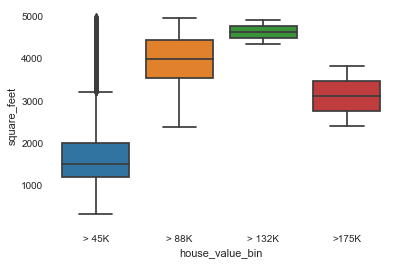

In [18]:
sns.boxplot(x ="house_value_bin", y = "square_feet", data=zillow_data)

Interestingly, when looking at home value versus square feet, we notice that square feet is not the only driver of house value. For example, it seems that the mean square feet of houses between $89 K and $132 K is higher than the more expensive houses. This is probably due to location (more urban versus rural) and potentially other features, like proximity to schools. Because it is a small number of samples (2 each), it is not worth doing a t-test, as the results won't have a significant impact in the overall result of the model. 

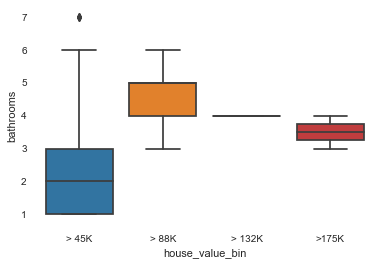

In [19]:
sns.boxplot(x ="house_value_bin", y = "bathrooms", data=zillow_data)

Similarly, we see that bathrooms and bedrooms are not necesarly the main drivers of value, given that there are houses with much higher bathroom and bedroom count, but lower house value. While does doesn't reject the null hypothesis - it does give us an indication about the fact that these key features might not be the most optimal ones for calculating house value.

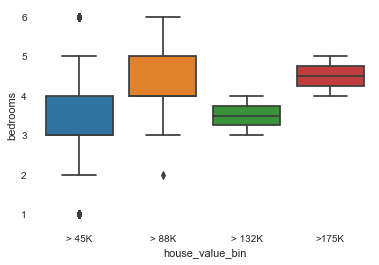

In [20]:
sns.boxplot(x ="house_value_bin", y = "bedrooms", data=zillow_data)

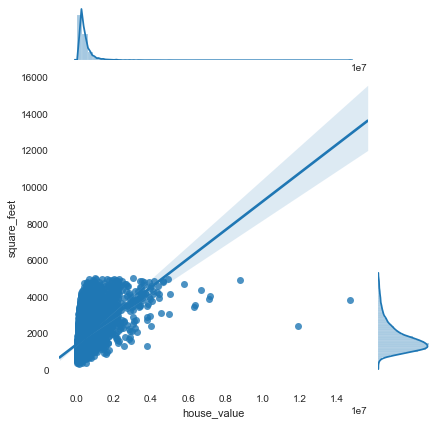

In [21]:
sns.jointplot(zillow_data.house_value, zillow_data.square_feet, data=zillow_data, kind = "reg")

I was curious to see the general distribution of the data, particularly the house value and the square feet. We see that they are not normally distributed, with both being very right skewed A pearson's test does show that both are positively correlated, and this gives us reassurance that at the very least we can use square feet to create a model that will perform better than a mean baseline. 

In [22]:
r, p = stats.pearsonr(zillow_data.house_value, zillow_data.square_feet)

print(r, p)

0.5176419084586631 0.0


After finishing the advance modeling, I saw there was still an opportunity to improve the model. I was curious to see if there were any other features that could help improve our tests performance. I did a comparison between `house_value` and `lotsizesquarefeet`, but there seems to be very little correlation. There is a significant number of outliers that are perhaps affecting the skew, and this might something that perhaps could be combined with the calculated square feet of the house to get a calculated total feet of the property.

In [23]:
r, p = stats.pearsonr(zillow_data.house_value, zillow_data.lotsizesquarefeet)

print(r, p)

0.08129580825051941 1.1805863733262084e-18


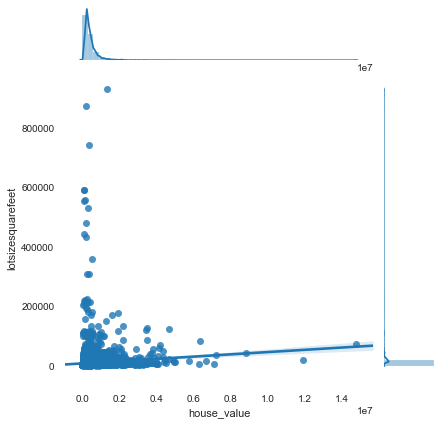

In [24]:
sns.jointplot(zillow_data.house_value, zillow_data.lotsizesquarefeet, data=zillow_data, kind = "reg")

__________

# Geographical Tax Distribution

From the customer's email:

>We'd also like to know the distribution of tax rates for each county.
> The data should have the tax amounts and tax value of the home, so it shouldn't be too hard to calculate. Please include in your report to us the distribution of tax rates for each county so that we can see how much they vary within the properties in the county and the rates the bulk of the properties sit around.

In [25]:
geo_data = wrangle_zillow.wrangle_geo_data(plain_data)

In [26]:
geo_data.groupby("county")["tax_rates"].count()

county
Los Angeles       12388
Orange County      2780
Ventura County      788
Name: tax_rates, dtype: int64

In [27]:
tax_rates = geo_data.groupby("county")["tax_rates"].mean()

print(f'''

The average tax rate for Los Angeles is: {tax_rates[0]:.2f}%
The average tax rate for Orange county is: {tax_rates[1]:.2f}%
The average tax rate for Ventura county is: {tax_rates[2]:.2f}%
''')



The average tax rate for Los Angeles is: 1.37%
The average tax rate for Orange county is: 1.21%
The average tax rate for Ventura county is: 1.15%



Text(0.5, 0.98, 'Tax rate distributions')

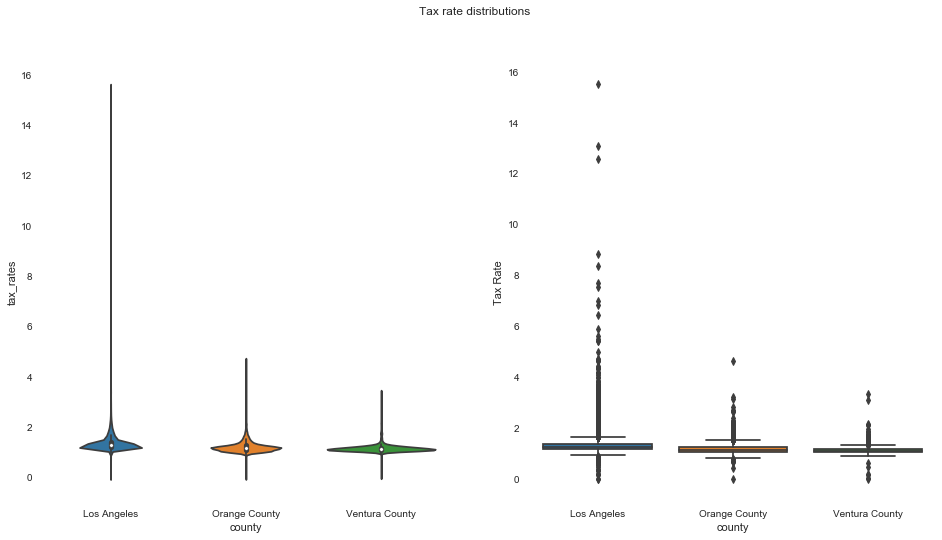

In [28]:
figure, axes = plt.subplots(1,2, figsize=(16,8))
sns.violinplot("county", "tax_rates", data=geo_data, ax=axes[0])
sns.boxplot("county", "tax_rates", data=geo_data, ax=axes[1])
plt.ylabel("Tax Rate")
plt.suptitle("Tax rate distributions")

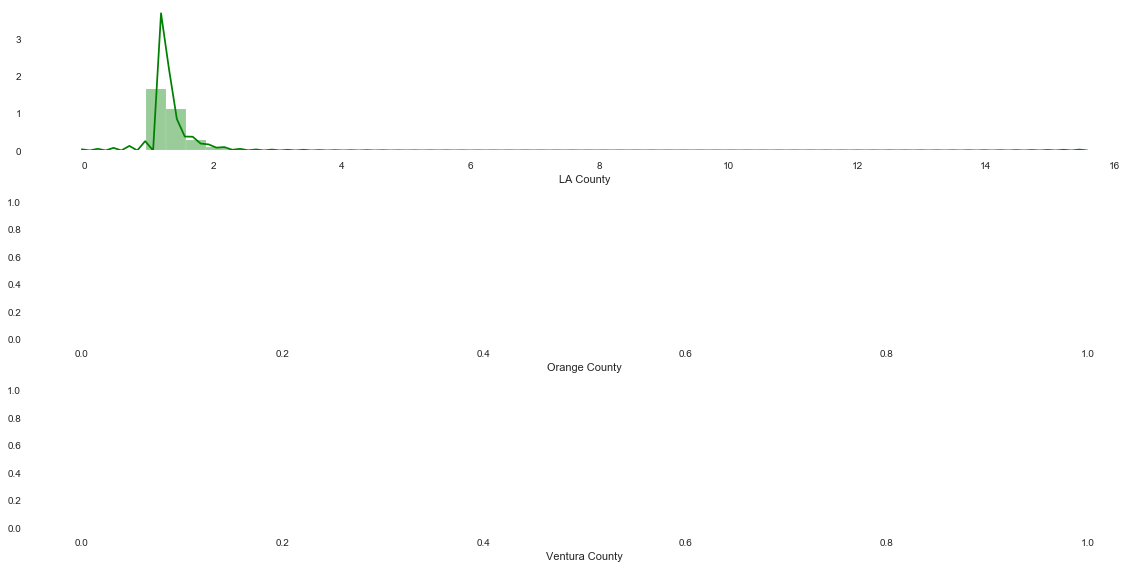

In [29]:
tax_rates_LA = geo_data[geo_data["county"] == "Los Angeles"].tax_rates
tax_rates_OC = geo_data[geo_data["county"] == "Orange"].tax_rates
tax_rates_V = geo_data[geo_data["county"] == "Ventura"].tax_rates

figure, axes = plt.subplots(3,1, figsize=(16,8))
sns.distplot(tax_rates_LA, axlabel="LA County", color="g", ax=axes[0])
sns.distplot(tax_rates_OC, axlabel="Orange County", color="y", ax=axes[1])
sns.distplot(tax_rates_V,axlabel="Ventura County", color="b", ax=axes[2])
figure.tight_layout()

## Key Take-aways:


In [30]:
print(f'''

* Los Angeles county has, on average, the highest tax_rate. That being said, the base majority of the properties in the dataset would fall under the LA county. 
    * Los Angles max tax rate is: {geo_data.groupby("county")["tax_rates"].max()[0]:.0f}%
    * Because there are so many outliers, the mean is likely not as accurate, the
      median is a better indicator, which is: {geo_data.groupby("county")["tax_rates"].median()[0]:.0f}%
* Orange County has the second highest tax rate average
    * It has a max tax rate of: {geo_data.groupby("county")["tax_rates"].max()[1]:.0f}%
    * Although it does not include as many outliers as LA, it still has a fair number, so the median is: {geo_data.groupby("county")["tax_rates"].median()[1]:.0f}%
* Ventura county has the smallest average tax rate
    * It has a max tax rate of: {geo_data.groupby("county")["tax_rates"].max()[2]:.0f}%
    * A median of: {geo_data.groupby("county")["tax_rates"].median()[1]:.0f}%
      
From the box plot and whisker plot above, we can see that it is not a very normally distributed rate, with the data for all three counties being skewed towards the left, due to the fact that there a lot of outliers.
The reason for this distribution is likely due to the location of the property, as well as the number of features the property might have.       
''')



* Los Angeles county has, on average, the highest tax_rate. That being said, the base majority of the properties in the dataset would fall under the LA county. 
    * Los Angles max tax rate is: 16%
    * Because there are so many outliers, the mean is likely not as accurate, the
      median is a better indicator, which is: 1%
* Orange County has the second highest tax rate average
    * It has a max tax rate of: 5%
    * Although it does not include as many outliers as LA, it still has a fair number, so the median is: 1%
* Ventura county has the smallest average tax rate
    * It has a max tax rate of: 3%
    * A median of: 1%
      
From the box plot and whisker plot above, we can see that it is not a very normally distributed rate, with the data for all three counties being skewed towards the left, due to the fact that there a lot of outliers.
The reason for this distribution is likely due to the location of the property, as well as the number of features the property might have.

____________________

## Modeling

Now that the data has been cleaned and scaled, we are ready to create our model. I used a Linear Regression model, given that I noticed there were some strong correlations between our target data and our key features. This might become an issue later, as some of the features are highly dependent on each other, but that will be something we tackle after the MVP has been finalized. 

I created 4 individual models to begin with, and all of the predictions are stored in a new dataframe called `predictions`. This dataframe is what will be used to calculate the mean error metrics for evaluation.

In [31]:
# Linear Model using "Bedroom Count"
predictions = pd.DataFrame({"actual": y_train_mvp.house_value})


X_1 = trained_scaled[["bedrooms"]]
y_1 = y_train_mvp

lm = LinearRegression().fit(X_1, y_1)
predictions["lm_bedrooms"] = lm.predict(X_1)

In [32]:
# Linear Model using "Bathroom Count"

X_2 = trained_scaled[["bathrooms"]]
y_2 = y_train_mvp

lm = LinearRegression().fit(X_2, y_2)
predictions["lm_bathrooms"] = lm.predict(X_2)

In [33]:
# Linear Model using "square feet"

X_3 = trained_scaled[["square_feet"]]
y_3 = y_train_mvp

lm = LinearRegression().fit(X_3, y_3)
predictions["lm_square_feet"] = lm.predict(X_3)

In [34]:
# Linear Model using all three features

X_4 = trained_scaled
y_4 = y_train_mvp

lm = LinearRegression().fit(X_4, y_4)
predictions["lm_key_features"] = lm.predict(X_4)


Because `house_value` is not a normally distributed curve, I have decided to use the median, rather than the mean, as the baseline.

In [35]:
predictions["baseline"] = y_train_mvp["house_value"].median()

In [36]:
predictions.head()

,actual,lm_bedrooms,lm_bathrooms,lm_square_feet,lm_key_features,baseline
3870,48620.0,261725.524029,1.517947e+05,2.331192e+05,2.685604e+05,292753.5
3671,130309.0,390447.560205,3.862617e+05,2.159341e+05,2.206244e+05,292753.5
7902,244000.0,519169.596380,6.207287e+05,5.569399e+05,5.355492e+05,292753.5
4410,139037.0,261725.524029,1.517947e+05,1.148454e+05,1.487447e+05,292753.5
815,1021592.0,519169.596380,1.558597e+06,1.197505e+06,1.446380e+06,292753.5


## Evaluate

Now that the models have been finalized, we can focus on evaluating the models and figuring out which is the best performing ones. 

In [37]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))

actual             0.000000e+00
lm_bedrooms        2.247814e+11
lm_bathrooms       1.915813e+11
lm_square_feet     1.753371e+11
lm_key_features    1.710953e+11
baseline           2.506633e+11
dtype: float64

### Conclusion

By looking at the mean squared error - we can tell that our combined model has the smallest error.

However, because of the nature of the key features - and the fact that all three categories are dependent on each other - I will would not recommend using the combined model. Instead, I suggest using the lm square feet model, which still has a similar MSE to the combined model, but it avoids the complexity of combining dependent variables.

In order to ensure that the model actually works, and is not overfitted, we now pass our test data, and review the MSE scores between our train and test data.

In [38]:
X_3 = trained_scaled[["square_feet"]]
y_3 = y_train_mvp

lm = LinearRegression().fit(X_3, y_3)

In [39]:
train_mse = sklearn.metrics.mean_squared_error(predictions.actual, predictions.lm_square_feet)

For further assurance, we plot the actual values against the predicted ones (from our square_feet model only) to see how the model performs. As we can see, the values don't have a very strong correlation, but the model does perform better than the baseline.

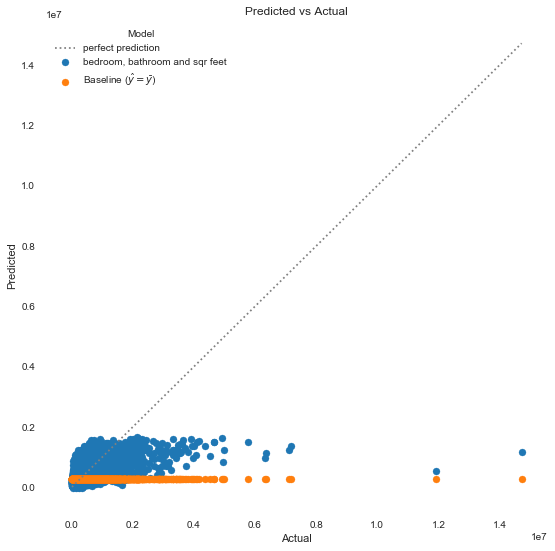

In [40]:
plt.figure(figsize=(9, 9))

plt.scatter(predictions.actual, predictions.lm_key_features, label="bedroom, bathroom and sqr feet", marker='o')
plt.scatter(predictions.actual, predictions.baseline, label=r'Baseline ($\hat{y} = \bar{y}$)', marker='o')
plt.plot(
    [predictions.actual.min(), predictions.actual.max()],
    [predictions.actual.min(), predictions.actual.max()],
    ls=':',
    label='perfect prediction',
    c='grey'
)

plt.legend(title='Model')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Predicted vs Actual')

plt.show()

Below I refitted the model with our X and y values for square_feet, and then passed the test data through it. We see that there is some difference between the test and train mse's, but they are within the expected difference. 

In [41]:
X_3 = trained_scaled[["square_feet"]]
y_3 = y_train_mvp

lm = LinearRegression().fit(X_3, y_3)

y_test_prediction = lm.predict(test_scaled[["square_feet"]])
y_test_actual = y_test_mvp

test_mse = sklearn.metrics.mean_squared_error(y_test_actual, y_test_prediction)

In [42]:
train_mse, test_mse

(175337123962.10748, 181991513954.3145)

In [43]:
# fig, axs = plt.subplots(2, 3, figsize=(13, 13), sharey=True)

# for ax, col in zip(axs.ravel(), predictions.iloc[:, 1:]):
#     explore.plot_residuals(ax, predictions.actual, predictions[col])
#     mse = sklearn.metrics.mean_squared_error(predictions.actual, predictions[col])
#     ax.set(title=f'{col} -- MSE: {mse:,.2}')      

In [44]:
print(f'''
Based on our fitted linear model, we would expect that for every square feet, the house value would increase by ${lm.coef_[0][0]:,.2f}. 

So we know that, even though our model is better than the baseline, it is still not as good as it can be.

R-square = {explained_variance_score(predictions.actual, predictions.lm_square_feet):.2f}
'''
)


Based on our fitted linear model, we would expect that for every square feet, the house value would increase by $1,552,048.06. 

So we know that, even though our model is better than the baseline, it is still not as good as it can be.

R-square = 0.26



________________

# Prefered Model: Model with feature engineering

Since we saw that our model was not performing as well as it could, I thought about using some domain knowledge and feature engineering to improve the model's performance. Given that the previus model was being affected by the fact that its key features were all dependent on each other, it was throwing off the predictions. So instead, I looked to see if I could engineer new features to help me create a better model. 

After a discussion with a senior Zillow Data Science team member, they suggested perhaps recalculating square feet so that it no longer was dependent on the other variables. 

With this idea, I did research and found that the average bedroom size in the US is 219 square feet$^1$, while the average bathroom is 40 square feet$^2$. With this in mind, I was able to create new features by multiplying the average to the number of rooms, then subtracting the new square meters from the total square feet. This way, the number of bedrooms and bathrooms were not dependent on the total square feet, and it also allowed each feature to be more significantly more impactful.

The new features were added to the wrangle_zillow.py file, to ensure that the data was still split evenly, and that there was not test data leackage. 

* $H_0$: A model using updated square footage, bedroom sqft and bathroom sqft as features to predict home value will not perform better than a model only using square footage.
* $H_a$: A model using updated square footage, bedroom sqft and bathroom sqft as features to predict home value will  perform better than a model only using square footage.

1: https://www.creditdonkey.com/average-bedroom-size.html

2: https://www.reference.com/business-finance/size-average-bathroom-56f5cc6a836759b6



In [45]:
X_train_adv = train[["sqft_without_bedroom_bathroom", "bedroom_sqft", "bathroom_sqft"]]
y_train_adv = train[["house_value"]]
X_test_adv = test[["sqft_without_bedroom_bathroom", "bedroom_sqft", "bathroom_sqft"]]
y_test_adv = test[["house_value"]]

# scaler, train_scaled, test_scaled = split_scale.min_max_scaler(X_train_adv, X_test_adv)

Because the key features have already been modified so that they are all on the same unit, we don't have to scale them before fitting them through the data.

In [46]:
# Linear Model using both sqft without bedroom and sqft for bedroom

X_adv = X_train_adv
y_adv = y_train_adv

lm = LinearRegression().fit(X_adv, y_adv)
predictions["lm_sqft"] = lm.predict(X_adv)

In [47]:
predictions.round(2).head()

,actual,lm_bedrooms,lm_bathrooms,lm_square_feet,lm_key_features,baseline,lm_sqft
3870,48620.0,261725.52,151794.67,233119.16,268560.45,292753.5,268560.45
3671,130309.0,390447.56,386261.68,215934.08,220624.45,292753.5,220624.45
7902,244000.0,519169.60,620728.68,556939.87,535549.21,292753.5,535549.21
4410,139037.0,261725.52,151794.67,114845.41,148744.71,292753.5,148744.71
815,1021592.0,519169.60,1558596.68,1197505.08,1446379.56,292753.5,1446379.56


As before, we used a Linear Regression model, and we fitted it with our data. When we look at the MSE to compare whether it is better than our previous models, we see that it is actually very similar to our key_features model, but because we know the features have been more strongly engineered to be less dependent, we have a much higher confidence in our new model being more accurate.

In [48]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))

actual             0.000000e+00
lm_bedrooms        2.247814e+11
lm_bathrooms       1.915813e+11
lm_square_feet     1.753371e+11
lm_key_features    1.710953e+11
baseline           2.506633e+11
lm_sqft            1.710953e+11
dtype: float64

In [49]:
print(f'''

Summary of coefficients:

For every square foot (that isn't a bedroom or a bathroon) increase, 
we expect the value of the home to increase by: ${lm.coef_[0][0]:,.0f}

For every bedroom square feet, we can expect the value of the home to decrease by: ${lm.coef_[0][1]:,.0f}

For every bathroom square feet, we can expect the value of the home to decrease by: ${lm.coef_[0][2]:,.0f}

If a property has no square footage of any kind (meaning X values equal 0), 
then the value of the home would be: ${lm.intercept_[0]:,.0f}. The reason why it's a negative value is likely becasue
there are likely other features that could help calculate the value, but at the moment we are missing, and it is 
leading to an unaccounted total of ~$8,000.


''')



Summary of coefficients:

For every square foot (that isn't a bedroom or a bathroon) increase, 
we expect the value of the home to increase by: $341

For every bedroom square feet, we can expect the value of the home to decrease by: $-97

For every bathroom square feet, we can expect the value of the home to decrease by: $1,978

If a property has no square footage of any kind (meaning X values equal 0), 
then the value of the home would be: $-7,707. The reason why it's a negative value is likely becasue
there are likely other features that could help calculate the value, but at the moment we are missing, and it is 
leading to an unaccounted total of ~$8,000.





# Evaluate

We evaluate our new model by passing the test data, and it performs 

In [50]:
X_adv = X_train_adv
y_adv = y_train_adv

lm = LinearRegression().fit(X_adv, y_adv)

y_test_prediction_adv = lm.predict(X_test_adv[["sqft_without_bedroom_bathroom", "bedroom_sqft", "bathroom_sqft"]])
y_test_actual_adv = y_test_adv

test_mse_adv = sklearn.metrics.mean_squared_error(y_test_actual_adv, y_test_prediction_adv)
train_mse_adv = sklearn.metrics.mean_squared_error(predictions.actual, predictions.lm_sqft)

print(f'''

Our test MSE is: {test_mse_adv:,.0}
Our train MSE is: {train_mse_adv:,.0}

The difference is {(train_mse_adv - test_mse_adv)/test_mse_adv * 100:.0f}% 
'''
)



Our test MSE is: 2e+11
Our train MSE is: 2e+11

The difference is -2% 



In [51]:
import math

print(f'''
On avg, our new model is, on average, off by ${math.sqrt(test_mse_adv):,.0f}, while the baseline model is off, on average, by ${math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.baseline)):,.0f}.
Our second best performing model had an RMSE of ${math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.lm_square_feet)):,.0f}

Our models R-square value is: {explained_variance_score(predictions.actual, predictions.lm_sqft):.2f}
Percent of variance in y explained by x = {round(explained_variance_score(predictions.actual, predictions.lm_sqft) *100,0)}%

''')


On avg, our new model is, on average, off by $416,856, while the baseline model is off, on average, by $500,663.
Our second best performing model had an RMSE of $418,733

Our models R-square value is: 0.28
Percent of variance in y explained by x = 28.0%




# Conclusion

Because our RMSE and R-square values are better for our new model than the model using the standard number of bedrooms, bathrooms and square meeters, we can conclude that this is a better way to estimate home value. One interesting thing that I concluded from the coefficients is that the bathroom square footage is considered to be a much heavier indicator of value, and hence, the more bathroom square feet that a house has, the higher the value. 

After doing some research, I found that individuals usually see the number of bedrooms as the higher indicator of value, and henced try to create smaller rooms to inflate the number listed. However, because for this case we are not calculating the value that someone would sell their house to, but rather what the tax value of the house is, which is why the bedroom square footage is giving a negative coefficient. As such, we shouldn't consider tradidional features, and instead focus on what tax assessors look at when assessing homes. In this case, bathroom size is a much better indicator of the *quality* of the home, because if there are more bathrooms, it can be expected that the rest of the house will also be bigger. Other luxury items that could potentially help us calculate the tax value are garage size and fireplace or pool size. Unfortunately, in this dataset, these features have a lot of null values, and as such couldn't be used for modeling, as the sample size would be too small.

Another key area that could be having a large impact is location. Location is hard to assess from the data, because despite having latitude and longitude information, a linear regression model can't really interpret that type of data. We would need to do a clustering algorithm first to potentially group locations with higher value. 

__________

## Model with Land Size

Another model that I thought could help influence the total value of the property was the lot size. After doing some reaserch, I found that the `calculatedsquarefeet` feature only includes the finished "living" space, and does not include the lot area. As one would assume, the bigger the lot, the bigger the value of the house. As such, I engenieered a new feature called `total_area` that was calculated by adding the `sqft_without_bedroom_bathroom` and `lotsizesquarefeet`, which contains information about the size of the lot the house is in. 

* $H_0$: A model using lot area will not perform better than a model without land area
* $H_a$: A model using lot area will perform better than a model without land area

In [52]:
X_train_adv_2 = train[["total_area", "bathroom_sqft", "bedroom_sqft"]]
y_train_adv_2 = train[["house_value"]]
X_test_adv_2 = test[["total_area", "bathroom_sqft", "bedroom_sqft"]]
y_test_adv_2 = test[["house_value"]]

# scaler, train_scaled, test_scaled = split_scale.min_max_scaler(X_train_adv_2, X_test_adv_2)

X_adv_2 = X_train_adv_2
y_adv_2 = y_train_adv

lm = LinearRegression().fit(X_adv_2, y_adv_2)
predictions["lm_sqft_location_sqft"] = lm.predict(X_adv_2)

In [53]:
print(f'''
On avg, our new model is, on average, off by ${math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.lm_sqft_location_sqft)):,.0f}, while the baseline model is off, on average, by ${math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.baseline)):,.0f}.
Our second best performing model had an RMSE of ${math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.lm_sqft)):,.0f}

Our models R-square value is: {explained_variance_score(predictions.actual, predictions.lm_sqft_location_sqft):.3f}
Percent of variance in y explained by x = {round(explained_variance_score(predictions.actual, predictions.lm_sqft_location_sqft) *100,1)}%

''')


On avg, our new model is, on average, off by $436,031, while the baseline model is off, on average, by $500,663.
Our second best performing model had an RMSE of $413,637

Our models R-square value is: 0.199
Percent of variance in y explained by x = 19.9%




In [54]:
print(f'''

Summary of coefficients:

For every square foot (that isn't a bedroom or a bathroon) increase, 
we expect the value of the home to increase by: ${lm.coef_[0][0]:,.0f}

For every bedroom square feet, we can expect the value of the home to decrease by: ${lm.coef_[0][1]:,.0f}

For every bathroom square feet, we can expect the value of the home to decrease by: ${lm.coef_[0][2]:,.0f}

''')



Summary of coefficients:

For every square foot (that isn't a bedroom or a bathroon) increase, 
we expect the value of the home to increase by: $1

For every bedroom square feet, we can expect the value of the home to decrease by: $6,412

For every bathroom square feet, we can expect the value of the home to decrease by: $-190




## Conclusion

Interestingly enough - this model does not perform as well as our previous model. This could be to the fact that larger lots might be largest becasue they are in more rural areas, meaning that their calculated value is actually less than the smaller lots near more urban areas, and cost significantly more. Given that our $R^2$ and MSE are worse, we reject the null hypothesis. We do not look at the p-value here because we don't need to know if the two values are significantly different. Even though they are fairly similar, the added complexity of this model makes me more confident that the previous model is a better altearnative, as it requires less feature engineering and the coefficients seem more realistic.